### By default
case 1:
- Amplitude 0.1, 30 sets, uniform distribution with (0.05, 0.1, 30), with noise amp of 0.01

case 2:
- Amplitude 0.1, 30 sets, Normal distribution with (1, 0.5, 30), with noise amp of 0.01

case 3:


In [1]:
#@title Parameters
from ipywidgets import FloatText, Checkbox, VBox, Dropdown
import ipywidgets as widgets

currentAmp = FloatText(description='Amplitude:', value=0.1)
sets = FloatText(description='sets:', value=15)
noiseSD = FloatText(description='noiseSD:', value=0.01)

vb = VBox(children = [currentAmp, sets])
with_noise = Checkbox(description='Add noise')

def add_noise(button):
    if button['new']:
        vb.children = [currentAmp, sets, noiseSD]
    else:
        vb.children = [currentAmp, sets]

with_noise.observe(add_noise, names='value')
display(with_noise)
display(vb)

Checkbox(value=False, description='Add noise')

In [2]:
#@title Distribution
from ipywidgets import FloatText, Checkbox, VBox, Dropdown
import ipywidgets as widgets

distribution = Dropdown(description='distribution:', options=["uniform", "normal", "poisson"], value="uniform")
low = FloatText(description='low:', value=0.05)
high = FloatText(description='high:', value=0.1)
leng = FloatText(description='size:', value=sets.value)
mean = FloatText(description='mean:', value=1)
sd = FloatText(description='SD:', value=0.5)
lam = FloatText(description='lam', value=3)

vb2 = VBox(children = [low, high, leng])

def change_widgets(button):
    if button['new'] == "uniform":
        vb2.children = [low, high, leng]
    elif button['new'] == "normal":
        vb2.children = [mean, sd, leng]
    elif button['new'] == "poisson":
        vb2.children = [lam, sets]

distribution.observe(change_widgets, names='value')
display(distribution)
display(vb2)

Dropdown(description='distribution:', options=('uniform', 'normal', 'poisson'), value='uniform')

In [3]:
#@title Set Delays
delayP1P2 = 0.1 #@param {type:"number"}
delayP2P1 =  0.3#@param {type:"number"}

# References

References:

1) https://www.neuron.yale.edu/neuron/static/new_doc/programming/hocsyntax.html

2) https://www.neuron.yale.edu/neuron/static/new_doc/programming/python.html

3) https://www.neuron.yale.edu/neuron/static/py_doc/programming/python.html

4) https://www.geeksforgeeks.org/single-neuron-neural-network-python/

5) https://github.com/piazentin/ksets

6) AP - https://www.moleculardevices.com/applications/
patch-clamp-electrophysiology/what-action-potential#gref

7) https://www.neuron.yale.edu/neuron/static/py_doc/modelspec/programmatic/network/netcon.html

8) http://neupy.com/apidocs/neupy.algorithms.associative.hebb.html

9) https://qbi-software.github.io/NEURON-tutorial/lessons/network

10) https://www.neuron.yale.edu/neuron/static/py_doc/modelspec/programmatic/topology/geometry.html

11) http://www.cnel.ufl.edu/courses/EEL6814/chapter6.pdf

12) https://www.slideshare.net/mentelibre/hebbian-learning

13) http://www.diva-portal.org/smash/get/diva2:1089220/FULLTEXT02

# Stage 1:Importing required libraries

In [4]:
pip install neuron

     |████████████████████████████████| 15.0 MB 5.6 MB/s 


In [5]:
import time
totalstart = time.time()
import os
if os.getcwd() != "/content":
    # we are not in google colab, assume hebbian library is in current dir
    from hebb import ORN, MCELL, GCELL
else:
    # download from git
    import shutil, requests
    url = 'https://cloud.operationtulip.com/s/t8nbn8Y582w94P3/download/git.zip'
    response = requests.get(url, stream=True)
    with open('git.zip', 'wb') as out_file:
        shutil.copyfileobj(response.raw, out_file)
    del response
    import zipfile
    with zipfile.ZipFile('git.zip', 'r') as zip_ref:
        zip_ref.extractall('')
    from hebb_test import ORN, MCELL, GCELL

In [6]:
from neuron import h                     #.h is a HOC object instanced & gui from neuron can also be imported 
from neuron.units import ms,mV
h.load_file('stdrun.hoc')                #Allows us to do a high level simulation
  
import matplotlib.pyplot as plt1

import numpy as np
from scipy.stats import poisson
import seaborn as sb

from bokeh.io import output_notebook
import bokeh.plotting as plt2
output_notebook()



# Helper Functions

In [7]:
def stairstep(lo: float, hi: float, duration: int, max_duration: int = 200, noise: list = []) -> list:
    # duration and max_duration are in ms
    ans = [lo if i < duration else hi for i in range(0,max_duration)]
    if len(noise) == 0:
        return ans
    else:
        assert len(ans) == len(noise)
        return [ans[i]+noise[i] for i in range(len(ans))]
    # return [0+0.8*(i/duration) if i < duration else 0 for i in range(0,max_duration)]
    # visualize input 

In [8]:
def netConMaker(source, dest, weights, delay, threshold, place='axon', type='exc'):
    if place == 'axon':
        if type == 'exc':
            netcon = h.NetCon(source.axon(0.5)._ref_v, dest.dendexcisyn, sec=source.axon)
        elif type == 'inh':
            netcon = h.NetCon(source.axon(0.5)._ref_v, dest.dendinhisyn, sec=source.axon)
    elif place == 'soma':
        if type == 'exc':
            netcon = h.NetCon(source.soma(0.5)._ref_v, dest.dendexcisyn, sec=source.soma)
        elif type == 'inh':
            netcon = h.NetCon(source.soma(0.5)._ref_v, dest.dendinhisyn, sec=source.soma)
    netcon.weight[0] = weights
    netcon.delay = delay
    netcon.threshold = threshold
    return netcon

In [9]:
def latConMaker(source, dest, weights, delay, threshold, type='exc'):
    if type == 'exc':
        netcon = h.NetCon(source.dend(0.5)._ref_v, dest.dendexcisyn, sec=source.dend)
    else:
        netcon = h.NetCon(source.dend(0.5)._ref_v, dest.dendinhisyn, sec=source.dend)
    netcon.weight[0] = weights
    netcon.delay = delay
    netcon.threshold = threshold
    return netcon

In [10]:
def plotCell(source, name, addendum=''):
    recording_cell = source
    cell_axon = h.Vector().record(recording_cell.axon(0.5)._ref_v)
    cell_dend = h.Vector().record(recording_cell.dend(0.5)._ref_v)
    t = h.Vector().record(h._ref_t)

    h.finitialize(-70 * mV)
    h.continuerun(300 * ms)

    f = plt2.figure(x_axis_label='t (ms)', y_axis_label='v (mV)')
    f.line(t, list(cell_axon), line_width=1,legend_label=name+' axon '+addendum,line_color='black')
    f.line(t, list(cell_dend), line_width=2,legend_label=name+' dendrite '+addendum,line_color='red', line_dash='dashed')
    plt2.show(f)

In [11]:
import math
def generate_L_weight_delta(first, second):
    A_plus = 0.01
    A_minus = -0.011
    tau_pre =20*ms
    tau_post =20*ms
    delta_t = [(second[iter] - first[iter]) for iter in range(min(len(first),len(second)))]
    delta_w_list = [A_plus*math.exp(-delta_t[iter]/tau_post) if delta_t[iter] >=0 else A_minus*math.exp(delta_t[iter]/tau_pre) for iter in range(min(len(first),len(second)))]  
    delta_w = sum(delta_w_list)
    return delta_w

In [12]:
from IPython.display import HTML, display
import time

def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

# Weight Distribution

In [13]:
import numpy as np
if distribution.value == "uniform":
    weights = np.random.uniform(low.value, high.value, 2*int(leng.value)-1)
elif distribution.value == "normal":
    weights = np.random.normal(mean.value, sd.value, 2*int(leng.value)-1)
elif distribution.value == "poisson":
    weights = np.random.poisson(lam.value, 2*int(leng.value)-1)

# Stage 4: Coupling a neuron according to Freeman's KI Set with the weights given above

In [14]:
#Gives one 2 coupled neuron using freeman's topology in olfactory bulb
class CONNECTING:

    def __init__(self,M,weights,delay1=1,delay2=1):
        wMM=weights[0]
        
        self.M = M #Set no.
        self.th = -70
        self.maindelay = 0
        
        #Making 2 neurons
        self.cells=[]
        self.P1=MCELL(1,self.M)
        self.P2=MCELL(2,self.M)
        self.cells.append(self.P1)
        self.cells.append(self.P2)
        
        #Giving current pulse
        self.stim = h.IClamp(self.P1.dend(0.5))
        print(with_noise.value)
        if with_noise.value == True:
            self.noise = np.random.normal(0, noiseSD.value, 100)
            self.input = h.Vector(stairstep(0,currentAmp.value,10,100,self.noise))
            self.tv = h.Vector([i for i in range(100)])
            self.stim.delay = 10
            self.stim.dur = 100
            self.stim.amp = 0
            self.input.play(self.stim._ref_amp, self.tv, True) 
        else:
            self.stim.delay = 10
            self.stim.dur = 100
            self.stim.amp = currentAmp.value
        
                
        #Connecting P1 to P2
        self.nc1 = h.NetCon(self.P1.axon(0.5)._ref_v,self.P2.dendexcisyn,sec=self.P1.axon)   # P1.axon to P2.dend
        self.nc1.weight[0] = weights[M]
        print("mutual weight is ", weights[M])
        self.nc1.delay = delayP1P2 #tP1P2
        self.nc1.threshold = self.th
        
        #Connecting P2 to P1
        self.nc2 = h.NetCon(self.P2.axon(0.5)._ref_v,self.P1.dendexcisyn,sec=self.P2.axon)    #P2.axon to P1.dend
        self.nc2.weight[0] = weights[M]
        self.nc2.delay = delayP2P1 #tP2P1
        self.nc2.threshold = self.th    

            

**Stage 5: Laterally connect each set of 2 coupled neurons according to Freeman's KI Set**

In [15]:
class LATERAL:

    def __init__(self,N,weights):
        wMML=weights
        #wMML=0.1
        
        self.N = N
        self.th = -70
        self.maindelay = 20
        self.sets = []
        c=0
        for i in range(N):
            self.sets.append(CONNECTING(i,weights))
        
        self.netConArr = []
        for r in range(0,N-1):
          #Connecting P1[0] to P1[1]
          # make a list for easier access
          netConList = []
          netConList.append(h.NetCon(self.sets[r].P1.axon(0.5)._ref_v, self.sets[r+1].P1.dendexcisyn,sec=self.sets[r].P1.axon))
          netConList[0].weight[0]  = wMML[r+N]
          print("Lateral weight is", wMML[r+N])
          netConList[0].delay = self.maindelay+1
          netConList[0].threshold = self.th

          netConList.append(h.NetCon(self.sets[r+1].P1.axon(0.5)._ref_v, self.sets[r].P1.dendexcisyn, sec=self.sets[r+1].P1.axon))
          netConList[1].weight[0] = wMML[r+N]
          netConList[1].delay = self.maindelay+2
          netConList[1].threshold = self.th

          self.netConArr.append(netConList)

          # exec(f"self.nc11_{r} = h.NetCon(getattr(self.sets[r].P1.axon(0.5), '_ref_v'), self.sets[1+r].P1.dendexcisyn,sec=self.sets[r].P1.axon)")
          # exec(f"self.nc11_{r}.weight[0] = wMML[r+N]")
          # print("lateral weight is", wMML[r+N])
          # exec(f"self.nc11_{r}.delay = self.maindelay+1")
          # exec(f"self.nc11_{r}.threshold = self.th")
          # exec(f"self.nc12_{r} = h.NetCon(getattr(self.sets[1+r].P1.axon(0.5), '_ref_v'), self.sets[r].P1.dendexcisyn,sec=self.sets[1+r].P1.axon)")
          # exec(f"self.nc12_{r}.weight[0] = wMML[r+N]")
          # #print(wMML[r+N])
          # exec(f"self.nc12_{r}.delay = self.maindelay+2")
          # exec(f"self.nc12_{r}.threshold = self.th")

**Stage 6: Input the number of 2 coupled sets required (which are all laterally connected)**

In [16]:
#Give N value to get N no. of 2 coupled neurons laterally connected
size = int(sets.value)
given_input_from_user = size #  int(input('Enter the number of 2 coupled sets required: '))
L1=LATERAL(given_input_from_user,weights)
print(weights)

False
mutual weight is  0.05781599649539977
False
mutual weight is  0.05315903309277795
False
mutual weight is  0.060632680304678624
False
mutual weight is  0.05512949710718021
False
mutual weight is  0.050189455598795465
False
mutual weight is  0.06614912938541569
False
mutual weight is  0.07120320328584191
False
mutual weight is  0.06196087627126534
False
mutual weight is  0.06924671150050342
False
mutual weight is  0.09577117223831891
False
mutual weight is  0.07765153553812568
False
mutual weight is  0.06625758936409923
False
mutual weight is  0.07852101473687925
False
mutual weight is  0.08660825457428559
False
mutual weight is  0.09658371553586892
Lateral weight is 0.05421317184248425
Lateral weight is 0.08124504654133065
Lateral weight is 0.09145107594251646
Lateral weight is 0.06450515891404714
Lateral weight is 0.07994216814326435
Lateral weight is 0.07781362030665231
Lateral weight is 0.08884059354001099
Lateral weight is 0.09531003424518047
Lateral weight is 0.08519446609239

# Stage 7: Visualize the topology of the neurons and the 3D space they are in. Also visualize the density mechanisms added to each neuron of a set

In [17]:
# h.topology()

In [18]:
from neuron import h, gui2
gui2.set_backend('jupyter')
ps = gui2.PlotShape()
ps.variable('v')
ps.show(0)

<IPython.core.display.Javascript object>

In [19]:
recording_cell = L1.sets[0].stim
graph = h.Vector().record(recording_cell._ref_i)
t = h.Vector().record(h._ref_t)

h.finitialize(-70 * mV)
h.continuerun(300*ms)

f = plt2.figure(x_axis_label='t (ms)', y_axis_label='v (mV)')
f.line(t, list(graph), line_width=2,legend_label='Input',line_color='black')
plt2.show(f)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

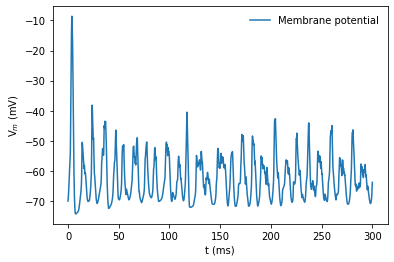

<IPython.core.display.Javascript object>

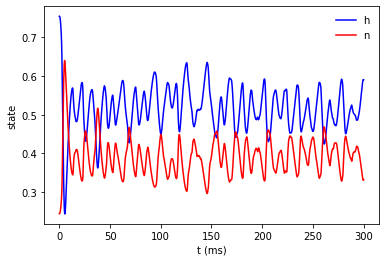

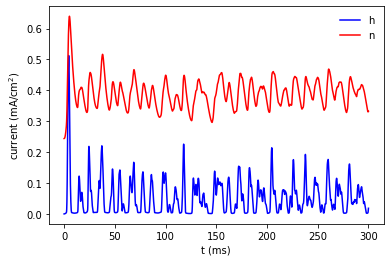

In [20]:
import numpy as np
from matplotlib import pyplot

vvecAArr=[]
kvecAArr=[]
mvecAArr=[]
hvecAArr=[]
nvecAArr=[]
for i in L1.sets:
    for cell in i.cells:
        checkCell = cell.axon(0.5)
        vvecAArr.append(h.Vector().record(checkCell._ref_v))
        kvecAArr.append(h.Vector().record(checkCell.k_ion._ref_ik))
        # nvecA = h.Vector().record(checkCell.na_ion._ref_ina)
        mvecAArr.append(h.Vector().record(checkCell.hh._ref_m))
        hvecAArr.append(h.Vector().record(checkCell.hh._ref_h))
        nvecAArr.append(h.Vector().record(checkCell.hh._ref_n))

tvec = h.Vector().record(h._ref_t)

h.finitialize(-70)
h.continuerun(300)

vvecMean = np.mean(vvecAArr,axis=0)
hvecMean = np.mean(hvecAArr,axis=0)
nvecMean = np.mean(nvecAArr,axis=0)
kvecMean = np.mean(kvecAArr,axis=0)

fig = pyplot.figure()
pyplot.plot(tvec, vvecMean, label="Membrane potential")
pyplot.xlabel('t (ms)')
pyplot.ylabel('V$_m$ (mV)')
pyplot.legend(frameon=False)

fig = pyplot.figure()
pyplot.plot(tvec, hvecMean, '-b', label='h')
pyplot.plot(tvec, nvecMean, '-r', label='n')
pyplot.xlabel('t (ms)')
pyplot.ylabel('state')
pyplot.legend(frameon=False)


fig = pyplot.figure()
pyplot.plot(tvec, kvecMean, '-b', label='h')
pyplot.plot(tvec, nvecMean, '-r', label='n')
pyplot.xlabel('t (ms)')
pyplot.ylabel('current (mA/cm$^2$)')
pyplot.legend(frameon=False)

No handles with labels found to put in legend.


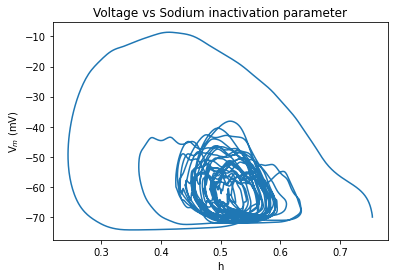

In [21]:
fig = pyplot.figure()
pyplot.plot(hvecMean, vvecMean, label="")
pyplot.xlabel('h')
pyplot.ylabel('V$_m$ (mV)')
pyplot.title('Voltage vs Sodium inactivation parameter')
pyplot.legend(frameon=False)

No handles with labels found to put in legend.


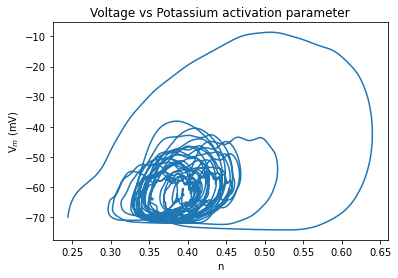

In [22]:
fig = pyplot.figure()
pyplot.plot(nvecMean, vvecMean, label="")
pyplot.xlabel('n')
pyplot.ylabel('V$_m$ (mV)')
pyplot.title('Voltage vs Potassium activation parameter')
pyplot.legend(frameon=False)

# Stage 8: Record & visualize the voltage values at each axon and dendrite

In [23]:
recording_cell = L1.sets[4].P1
print("The voltage at P1's axon:", recording_cell.axon(0.5).v)
axon_P1 = h.Vector().record(recording_cell.axon(0.5)._ref_v)
print("The voltage at P1's dendrite:", recording_cell.dend(0.5).v)
dend_P1 = h.Vector().record(recording_cell.dend(0.5)._ref_v)
t = h.Vector().record(h._ref_t)

h.finitialize(-70 * mV)
h.continuerun(300 * ms)

f = plt2.figure(x_axis_label='t (ms)', y_axis_label='v (mV)')
f.line(t, list(axon_P1), line_width=1,legend_label='P1 axon',line_color='black')
f.line(t, list(dend_P1), line_width=2,legend_label='P1 dend',line_color='red', line_dash='dashed')
plt2.show(f)

The voltage at P1's axon: -64.85647880838805
The voltage at P1's dendrite: -67.48876544419701


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [24]:
recording_cell = L1.sets[4].P2
axon_P2 = h.Vector().record(recording_cell.axon(0.5)._ref_v)
dend_P2 = h.Vector().record(recording_cell.dend(0.5)._ref_v)
t = h.Vector().record(h._ref_t)

h.finitialize(-70 * mV)
h.continuerun(300 * ms)

f = plt2.figure(x_axis_label='t (ms)', y_axis_label='v (mV)')
f.line(t, list(axon_P2), line_width=1,legend_label='P2 axon',line_color='black')
f.line(t, list(dend_P2), line_width=2,legend_label='P2 dend',line_color='red', line_dash='dashed')
plt2.show(f)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Scatter Plots of voltages

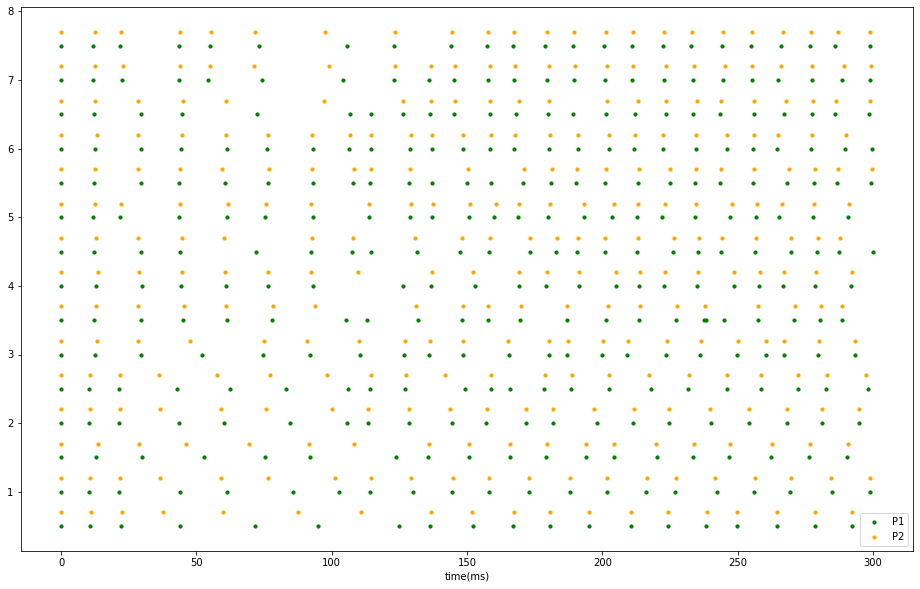

In [25]:
color=['green','orange']
label=['P1','P2']
plt1.figure(figsize=(16,10))
for j in range(len(L1.sets)):
  #for i,cell in enumerate(L1.sets[j].cells):
    plt1.scatter(L1.sets[j].cells[0].spike_times, [0.5 + 0.5*j for i in range(len(L1.sets[j].cells[0].spike_times))], s=10,color=color[0]) # for P1
    plt1.scatter(L1.sets[j].cells[1].spike_times, [0.7 + 0.5*j for i in range(len(L1.sets[j].cells[1].spike_times))], s=10, color=color[1])
plt1.xlabel('time(ms)')
plt1.legend(label)

In [26]:
# color=['green','orange']
# label=['P1','P2']
# plt1.figure(figsize=(16,10))
# for j in range(1):
#   #for i,cell in enumerate(L1.sets[j].cells):
#     plt1.vlines(L1.sets[j].cells[0].spike_times+(100*j), 0.5, 1,color=color[0]) # for P1
#     plt1.vlines(L1.sets[j].cells[1].spike_times+(100*j), 0.5, 1, color=color[1])
# plt1.xlabel('time(ms)')
# plt1.legend(label)


In [27]:
# color=['green','orange']
# label=['P2']
# plt1.figure(figsize=(16,11))
# for j in range(1):
#   #for i,cell in enumerate(L1.sets[j].cells):
#     plt1.vlines(L1.sets[j].cells[1].spike_times+(100*j), 1.5, 2,color=color[1]) # for P2
# plt1.xlabel('time(ms)')
# plt1.legend(label)

# Weights before learning

In [28]:
%load_ext google.colab.data_table
import pandas
P1_spike_times = list(L1.sets[0].cells[0].spike_times)
P2_spike_times = list(L1.sets[0].cells[1].spike_times)

padding = len(P1_spike_times) - len(P2_spike_times)
P2_spike_times.extend([0 for i in range(padding)]) if padding > 0 else P1_spike_times.extend([0 for i in range(-padding)])
# print(len(P1_spike_times), len(P2_spike_times))
data = {'P1 before learning': P1_spike_times, 'P2 before learning' : P2_spike_times}
pandas.DataFrame(data)

P1 before learning  P2 before learning
0                0.025               0.025
1               10.525              10.900
2               22.175              22.425
3               44.050              37.675
4               71.550              59.950
5               94.775              87.525
6              124.900             110.700
7              136.450             136.725
8              152.375             151.925
9              167.000             167.175
10             180.550             180.750
11             195.025             195.200
12             210.525             210.650
13             224.225             224.425
14             238.400             238.600
15             249.600             249.875
16             264.375             264.525
17             278.525             278.725
18             292.150             292.350

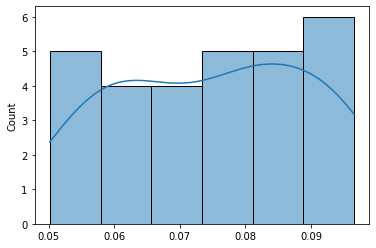

In [29]:
sb.histplot(weights, kde=True)

# Before learning Firing rate

In [30]:
fr_P1=[0 for i in range(len(L1.sets))]
fr_P2=[0 for i in range(len(L1.sets))]
for f in range(len(L1.sets)):
  t=list(L1.sets[f].cells[0].spike_times)
  #print("spikes of p1", t)
  t1=list(L1.sets[f].cells[1].spike_times)
  #print("spikes of p2", t1)
  fr_P1[f]=(len(t)/100)*1000
  fr_P2[f]=(len(t1)/100)*1000
#print("frequencies of P1 in each set", fr_P1)
#print("frequencies of P2 in each set", fr_P2)

c=[0 for i in range(size*2)]
for i in range(size):
  c[i*2]=fr_P1[i]
  c[i*2+1]=fr_P2[i]
print("Frequencies of each neuron before learning", c)

Frequencies of each neuron before learning [190.0, 190.0, 210.0, 210.0, 190.0, 190.0, 210.0, 210.0, 220.0, 210.0, 220.0, 220.0, 230.0, 200.0, 220.0, 220.0, 240.0, 220.0, 240.0, 240.0, 260.0, 240.0, 260.0, 250.0, 240.0, 220.0, 240.0, 240.0, 230.0, 230.0]


# Population Activity (Before Learning)

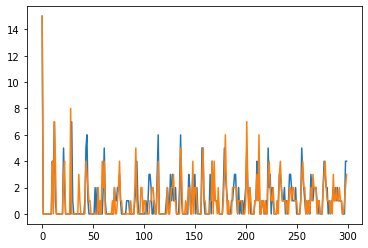

In [31]:
resolution = 1
import numpy as np
import math
M1_spike_times = [0 for i in range(0,300,resolution)]
M2_spike_times = [0 for i in range(0,300,resolution)]
for cell in L1.sets:
    for i in list(cell.cells[0].spike_times):
        M1_spike_times[math.floor(i)] += 1
    for i in list(cell.cells[1].spike_times):
        M2_spike_times[math.floor(i)] += 1
# M2_spike_times = np.array([list(cell.cells[1].spike_times) for cell in L1.sets])

import matplotlib.pyplot as plt
plt.plot(M1_spike_times)
plt.plot(M2_spike_times)

In [32]:
def generate_L_weight_delta(first, second):
    A_plus = 0.01
    A_minus = -0.0011
    tau_pre =20*ms
    tau_post =20*ms
    delta_t = [(second[iter] - first[iter]) for iter in range(min(len(first),len(second)))]
    delta_w_list = [A_plus*math.exp(-delta_t[iter]/tau_post) if delta_t[iter] >=0 else A_minus*math.exp(delta_t[iter]/tau_pre) for iter in range(min(len(first),len(second)))]  
    delta_w = sum(delta_w_list)
    return delta_w

### **Stage 9:Learning**

In [33]:
# epochs = 50
# import numpy as np
# import math
# out_1_1_data = []
# A_plus = 0.01      #0.2 to 2.5
# A_minus = -0.01
# tau_pre = 20*ms
# tau_post = 20*ms

# weights_rec = [[0 for i in range(epochs)] for j in range(len(L1.sets))]
# weights_rec_2 = [[0 for i in range(epochs)] for j in range(len(L1.sets))]
# L_weights_rec= [[0 for i in range(epochs)] for j in range(len(L1.sets)-1)]
# L_weights_rec_2= [[0 for i in range(epochs)] for j in range(len(L1.sets)-1)]

# for l in range(epochs):  
#     print("\niteration no is",l)
#     P1_data = []
#     print("\nmutual learning")
#     for i in range(len(L1.sets)):
#         h.continuerun(300 *ms)
#         out_1_1 = h.Vector().record(L1.sets[i].P1.axon(0.5)._ref_v)
#         # print("Spike times P{0}".format(1+i*2), list(L1.sets[i].P1.spike_times))
#         spike_1_1 = list(L1.sets[i].P1.spike_times)
#         out_1_2 = h.Vector().record(L1.sets[i].P2.dend(0.5)._ref_v)
#         spike_1_2 = list(L1.sets[i].P2.spike_times)
#         # print("Spike times P{0}".format(2+i*2), list(L1.sets[i].P2.spike_times))
#         t = h.Vector().record(h._ref_t)
#         h.finitialize(-70 * mV)
        
#         for k in range(1,3):
#             delta_t = [(spike_1_2[iter] - spike_1_1[iter]) for iter in range(min(len(spike_1_1),len(spike_1_2)))]
#             delta_w_list = [A_plus*math.exp(-delta_t[iter]/tau_post) if delta_t[iter] >=0.24 else A_minus*math.exp(delta_t[iter]/tau_pre) for iter in range(min(len(spike_1_1),len(spike_1_2)))]
#             delta_w = sum(delta_w_list)
#             exec(f"L1.sets[i].nc{k}.weight[0] += delta_w")         
#         P1_data.append(list(out_1_1))
#         print("weight:", L1.sets[i].nc1.weight[0])
#         weights_rec[i][l] = L1.sets[i].nc1.weight[0]
#         weights_rec_2[i][l] = L1.sets[i].nc2.weight[0]    



# #Lateral Learning
#     print("\tlateral learning")
#     for i in range(len(L1.sets)-1):
#       h.continuerun(300 *ms)
#       out_1_1 = h.Vector().record(L1.sets[i].P1.axon(0.5)._ref_v)
#       print("Spike times P{0}".format(1+2*i), list(L1.sets[i].P1.spike_times))
#       spike_1_1 = list(L1.sets[i].P1.spike_times)
#       out_2_1 = h.Vector().record(L1.sets[i+1].P1.axon(0.5)._ref_v)
#       print("Spike times P{0}".format(3+2*i), list(L1.sets[i+1].P1.spike_times))
#       spike_2_1 = list(L1.sets[i+1].P1.spike_times)
#       h.finitialize(-70 * mV)

#       # change the deltas
      
#       L1.netConArr[i][0].weight[0] += generate_L_weight_delta(spike_1_1, spike_2_1)
#       L1.netConArr[i][1].weight[0] += generate_L_weight_delta(spike_1_1, spike_2_1)

#       # Logging work

#       print(L1.netConArr[i][0].weight[0])
#       L_weights_rec[i][l] = L1.netConArr[i][0].weight[0]
#       L_weights_rec[i][l] = L1.netConArr[i][1].weight[0]
#       # exec(f"L1.nc11_{i}.weight[0] += generate_L_weight_delta(spike_1_1, spike_2_1)")
#       # exec(f"L1.nc12_{i}.weight[0] += generate_L_weight_delta(spike_1_1, spike_2_1)")
#       # exec(f"L1.nc11_{i}.weight[0] += generate_L_weight_delta(spike_M1_data[i], spike_M1_data[i+1])")
#       # exec(f"L1.nc12_{i}.weight[0] += generate_L_weight_delta(spike_M1_data[i+1], spike_M1_data[i])")
#       # print("lateral weight is : ",L1.nc11_0.weight[0])  
#       # L_weights_rec[i][l] = L1.nc11_0.weight[0]
#       # L_weights_rec_2[i][l]=L1.nc12_i.weight[0] 
#       # exec(f"print(L1.nc11_{i}.weight[0])")
#       # exec(f"L_weights_rec[i][l]=L1.nc11_{i}.weight[0]")
#       # exec(f"L_weights_rec_2[i][l]=L1.nc12_{i}.weight[0]")

In [34]:
import sys, time
tick = time.time()
epochs = 30
weight_data = []

out = display(progress(0, epochs), display_id=True)

for l in range(epochs):
    #print("iteration no is",l)
    out.update(progress(l, epochs))    
    # print("\nmutual learning")
    P1_axon_data = []
    P1_dend_data = []
    P2_axon_data = []
    P2_dend_data = []
    P1_spike_times = []
    P2_spike_times = []

    h.finitialize(-70* mV)
    h.continuerun(300*ms)
    t = h.Vector().record(h._ref_t)
    
    for i in range(len(L1.sets)):
        P1_axon_data.append(list(h.Vector().record(L1.sets[i].P1.axon(0.5)._ref_v)))
        P1_dend_data.append(list(h.Vector().record(L1.sets[i].P1.dend(0.5)._ref_v)))
        P1_spike_times.append(list(L1.sets[i].P1.spike_times))
        P2_axon_data.append(list(h.Vector().record(L1.sets[i].P2.axon(0.5)._ref_v)))
        P2_spike_times.append(list(L1.sets[i].P2.spike_times))
        P2_dend_data.append(list(h.Vector().record(L1.sets[i].P2.dend(0.5)._ref_v)))
   
    # h.finitialize(-70 * mV)

    for i in range(len(L1.sets)):
        # 2-coupled STDP-based learning
        L1.sets[i].nc1.weight[0] += generate_L_weight_delta(P1_spike_times[i], P2_spike_times[i])
        # logging
        # print("P1_axon", P1_spike_times[i], P2_spike_times[i])
        L1.sets[i].nc2.weight[0] += generate_L_weight_delta(P2_spike_times[i], P1_spike_times[i])
        
    # do a proper logging function
    weight_data.append(L1.sets[0].nc1.weight[0])


    #Lateral Learning
    for i in range(len(L1.sets)-1):
        # 2-coupled part
        L1.netConArr[i][0].weight[0] += generate_L_weight_delta(P1_spike_times[i], P1_spike_times[i+1])
        L1.netConArr[i][1].weight[0] += generate_L_weight_delta(P1_spike_times[i+1], P1_spike_times[i])
    

out.update(progress(epochs, epochs))    
tock = time.time()
print("The time it took to learn", tock-tick, "seconds")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The time it took to learn 25.541431188583374 seconds


<IPython.core.display.Javascript object>

## Weights after learning

In [35]:
%load_ext google.colab.data_table
import pandas
P1_spike_times = list(L1.sets[0].cells[0].spike_times)
P2_spike_times = list(L1.sets[0].cells[1].spike_times)

padding = len(P1_spike_times) - len(P2_spike_times)
P2_spike_times.extend([0 for i in range(padding)]) if padding > 0 else P1_spike_times.extend([0 for i in range(-padding)])
# print(len(P1_spike_times), len(P2_spike_times))
data = {'P1 before learning': P1_spike_times, 'P2 before learning' : P2_spike_times}
pandas.DataFrame(data)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The google.colab.data_table extension is already loaded. To reload it, use:

<IPython.core.display.Javascript object>


  %reload_ext google.colab.data_table


P1 before learning  P2 before learning
0                0.025               0.025
1               31.400              23.525
2               61.875              54.900
3               88.700              85.375
4              115.200             112.200
5              138.325             138.450
6              154.250             154.425
7              160.750             161.075
8              175.325             175.500
9              182.000             182.300
10             197.150             197.300
11             204.175             204.475
12             218.325             218.525
13             225.225             225.525
14             240.275             240.475
15             247.600             247.875
16             258.750             259.000
17             268.100             268.350
18             274.800             275.100
19             283.475             283.650
20             291.000             291.275

In [36]:
print(weights)

[0.057816   0.05315903 0.06063268 0.0551295  0.05018946 0.06614913
 0.0712032  0.06196088 0.06924671 0.09577117 0.07765154 0.06625759
 0.07852101 0.08660825 0.09658372 0.05421317 0.08124505 0.09145108
 0.06450516 0.07994217 0.07781362 0.08884059 0.09531003 0.08519447
 0.08623278 0.09217418 0.07825368 0.05935223 0.09612173]


**Stage 8: Record & visualize the voltage values at each axon and dendride after learning**

In [37]:
recording_cell = L1.sets[2].P1
dend_P1 = h.Vector().record(recording_cell.dend(0.5)._ref_v)
axon_P1 = h.Vector().record(recording_cell.axon(0.5)._ref_v)
t = h.Vector().record(h._ref_t)
print(recording_cell.axon(0.5).v)
h.finitialize(-70 * mV)
h.continuerun(200 * ms)

f = plt2.figure(x_axis_label='t (ms)', y_axis_label='v (mV)')
f.line(t, list(axon_P1), line_width=1,legend_label='P1 axon',line_color='black')
f.line(t, list(dend_P1), line_width=2,legend_label='P1 dend',line_color='red', line_dash='dashed')
plt2.show(f)

-73.28618504539519


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [38]:
recording_cell = L1.sets[2].P2
axon_P1 = h.Vector().record(recording_cell.soma(0.5)._ref_v)
dend_P1 = h.Vector().record(recording_cell.axon(0.5)._ref_v)
t = h.Vector().record(h._ref_t)

h.finitialize(-70 * mV)
h.continuerun(100 * ms)

f = plt2.figure(x_axis_label='t (ms)', y_axis_label='v (mV)')
f.line(t, list(axon_P1), line_width=1,legend_label='P2 axon',line_color='black')
f.line(t, list(dend_P1), line_width=2,legend_label='P2 dend',line_color='red', line_dash='dashed')
plt2.show(f)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [39]:
# print(weight_data)
f = plt2.figure(x_axis_label='epochs')
x = [i for i in range(epochs)]
f.line(x, weight_data, line_width=1, line_color='black')
plt2.show(f)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

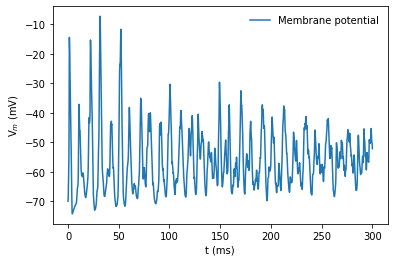

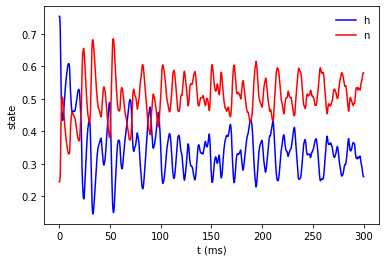

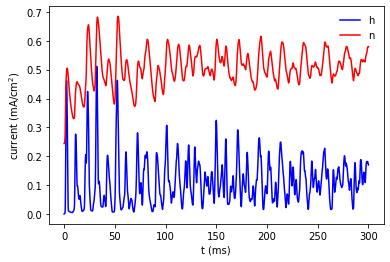

In [40]:
import numpy as np
from matplotlib import pyplot

vvecAArr=[]
kvecAArr=[]
mvecAArr=[]
hvecAArr=[]
nvecAArr=[]
for i in L1.sets:
    for cell in i.cells:
        checkCell = cell.axon(0.5)
        vvecAArr.append(h.Vector().record(checkCell._ref_v))
        kvecAArr.append(h.Vector().record(checkCell.k_ion._ref_ik))
        # nvecA = h.Vector().record(checkCell.na_ion._ref_ina)
        mvecAArr.append(h.Vector().record(checkCell.hh._ref_m))
        hvecAArr.append(h.Vector().record(checkCell.hh._ref_h))
        nvecAArr.append(h.Vector().record(checkCell.hh._ref_n))

tvec = h.Vector().record(h._ref_t)

h.finitialize(-70)
h.continuerun(300)

vvecMean = np.mean(vvecAArr,axis=0)
hvecMean = np.mean(hvecAArr,axis=0)
nvecMean = np.mean(nvecAArr,axis=0)
kvecMean = np.mean(kvecAArr,axis=0)

fig = pyplot.figure()
pyplot.plot(tvec, vvecMean, label="Membrane potential")
pyplot.xlabel('t (ms)')
pyplot.ylabel('V$_m$ (mV)')
pyplot.legend(frameon=False)

fig = pyplot.figure()
pyplot.plot(tvec, hvecMean, '-b', label='h')
pyplot.plot(tvec, nvecMean, '-r', label='n')
pyplot.xlabel('t (ms)')
pyplot.ylabel('state')
pyplot.legend(frameon=False)


fig = pyplot.figure()
pyplot.plot(tvec, kvecMean, '-b', label='h')
pyplot.plot(tvec, nvecMean, '-r', label='n')
pyplot.xlabel('t (ms)')
pyplot.ylabel('current (mA/cm$^2$)')
pyplot.legend(frameon=False)

No handles with labels found to put in legend.


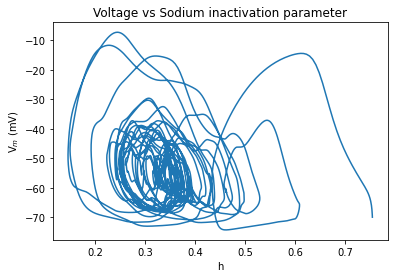

In [41]:
fig = pyplot.figure()
pyplot.plot(hvecMean, vvecMean, label="")
pyplot.xlabel('h')
pyplot.ylabel('V$_m$ (mV)')
pyplot.title('Voltage vs Sodium inactivation parameter')
pyplot.legend(frameon=False)

No handles with labels found to put in legend.


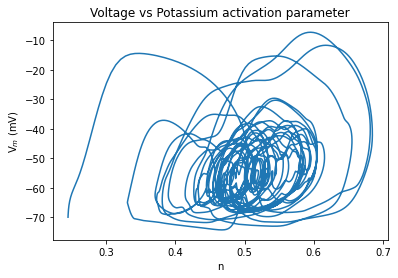

In [42]:
fig = pyplot.figure()
pyplot.plot(nvecMean, vvecMean, label="")
pyplot.xlabel('n')
pyplot.ylabel('V$_m$ (mV)')
pyplot.title('Voltage vs Potassium activation parameter')
pyplot.legend(frameon=False)

## Population Activity and weights

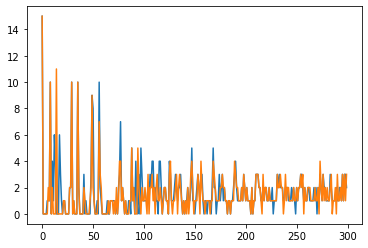

In [43]:
resolution = 1
import numpy as np
import math
M1_spike_times = [0 for i in range(0,300,resolution)]
M2_spike_times = [0 for i in range(0,300,resolution)]
for cell in L1.sets:
    for i in list(cell.cells[0].spike_times):
        M1_spike_times[math.floor(i)] += 1
    for i in list(cell.cells[1].spike_times):
        M2_spike_times[math.floor(i)] += 1
# M2_spike_times = np.array([list(cell.cells[1].spike_times) for cell in L1.sets])

import matplotlib.pyplot as plt
plt.plot(M1_spike_times)
plt.plot(M2_spike_times)

In [44]:
l1=[]
l2=[]
for i in range(size):
  l1.append(L1.sets[i].nc1.weight[0])
  l2.append(L1.sets[i].nc2.weight[0])
print(l1)
print(l2)

[6.499847971079062, 6.750248069822002, 6.973359563939704, 6.887617102834918, 6.736869485053307, 6.082860544383612, 5.824159940824827, 5.324364982170311, 4.820230809204831, 5.259558176723457, 5.066465248596046, 4.706068661714262, 5.636500672205352, 5.072034604852889, 6.442603358208363]
[0.03706174005699461, 0.02101579231623136, -0.005305243098770756, -0.021558822901897853, -0.0069907995099048595, -0.08202712639251573, -0.0625024677148042, -0.05100208995875767, -0.05893670590530456, -0.06749980563473079, -0.057250066507345064, -0.05478801112854182, -0.05149258373008391, -0.07106672528498159, -0.05268960044298796]


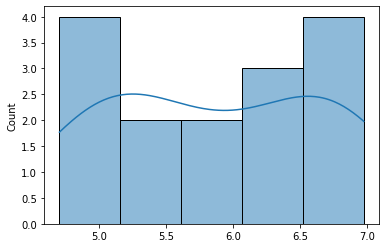

In [45]:
sb.histplot(l1, kde=True)

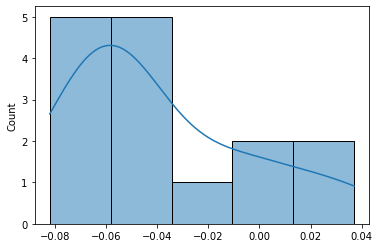

In [46]:
sb.histplot(l2, kde=True)

In [47]:
# count, bins, ignored = plt1.hist(weights_rec[0], 10)
# # Plot the distribution curve
# # plt1.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2) ),       linewidth=3, color='y')
# plt1.legend(label)
# plt1.xlabel('weights')
# plt1.ylabel('frequency')
# plt1.show()
# print(weights_rec[0])

In [48]:
# f = plt2.figure(x_axis_label='epoch', y_axis_label='weights')
# x = [i for i in range(len(L_weights_rec[0]))]
# f.line(x, L_weights_rec[3], line_width=1, legend_label='nc11', line_color='blue')
# f.line(x, L_weights_rec_2[0], line_width=2, legend_label='nc12', line_color='red', line_dash='dotted')
# plt2.show(f)

# Raster scan for short intervals

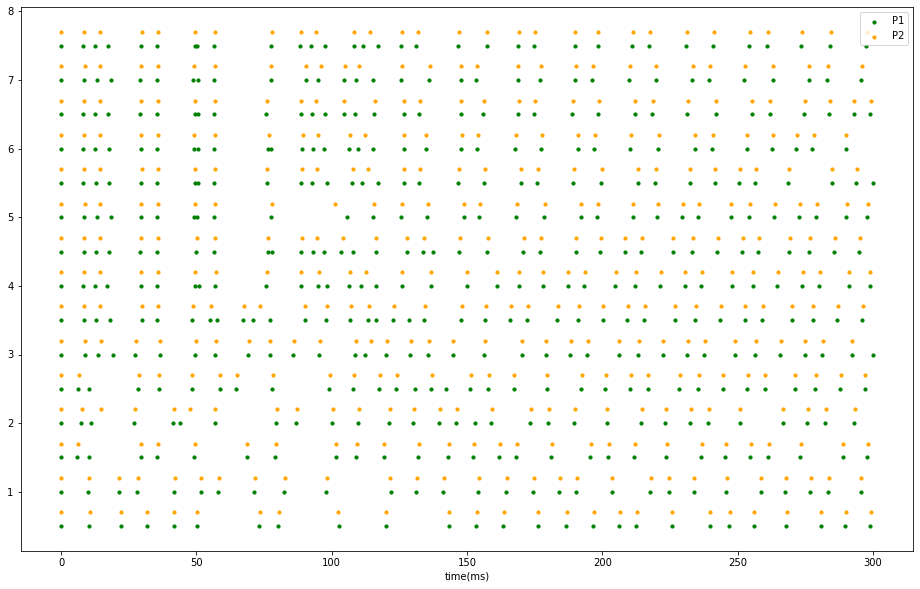

In [49]:
color=['green','orange']
label=['P1','P2']
plt1.figure(figsize=(16,10))
for j in range(len(L1.sets)):
  #for i,cell in enumerate(L1.sets[j].cells):
    plt1.scatter(L1.sets[j].cells[0].spike_times, [0.5 + 0.5*j for i in range(len(L1.sets[j].cells[0].spike_times))], s=10,color=color[0]) # for P1
    plt1.scatter(L1.sets[j].cells[1].spike_times, [0.7 + 0.5*j for i in range(len(L1.sets[j].cells[1].spike_times))], s=10, color=color[1])
plt1.xlabel('time(ms)')
plt1.legend(label)

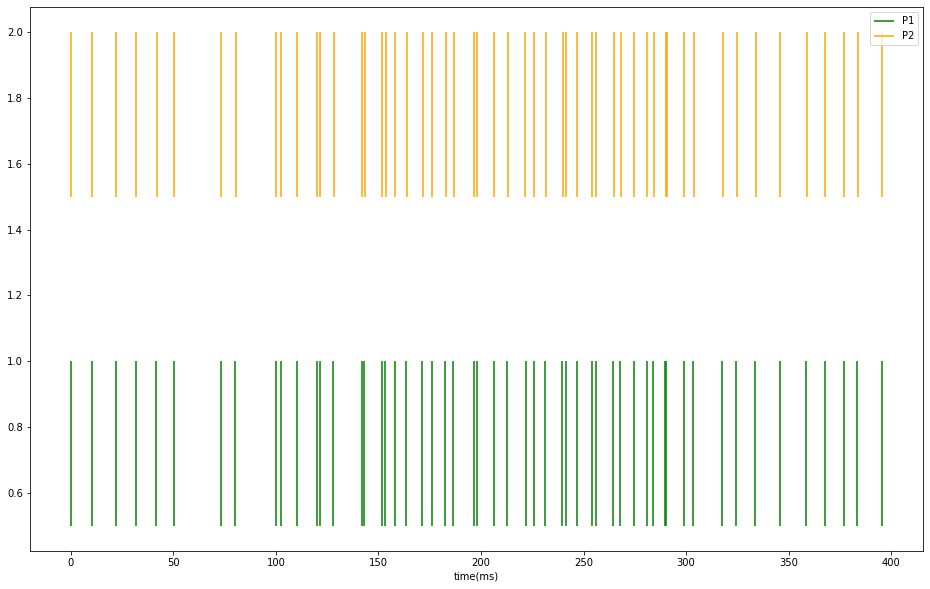

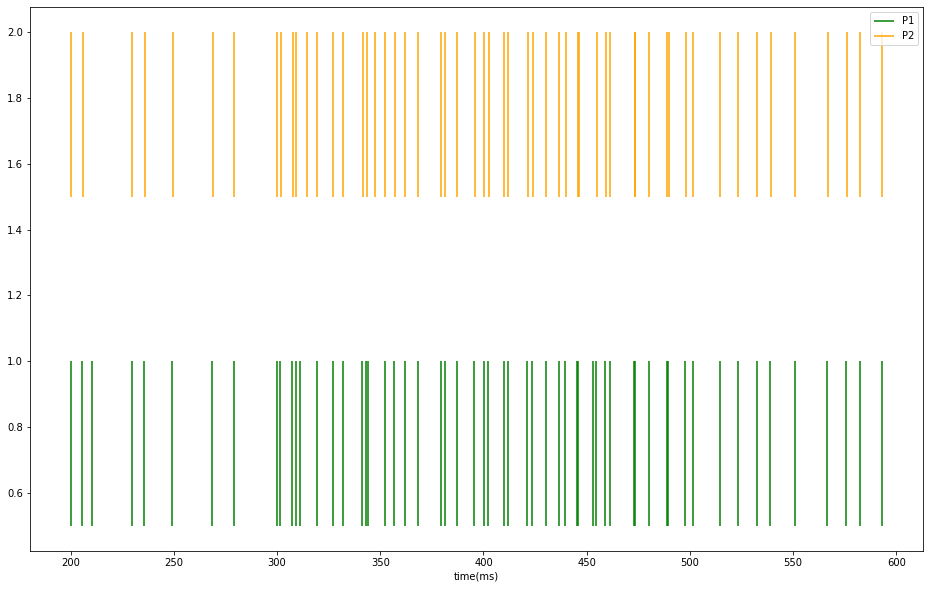

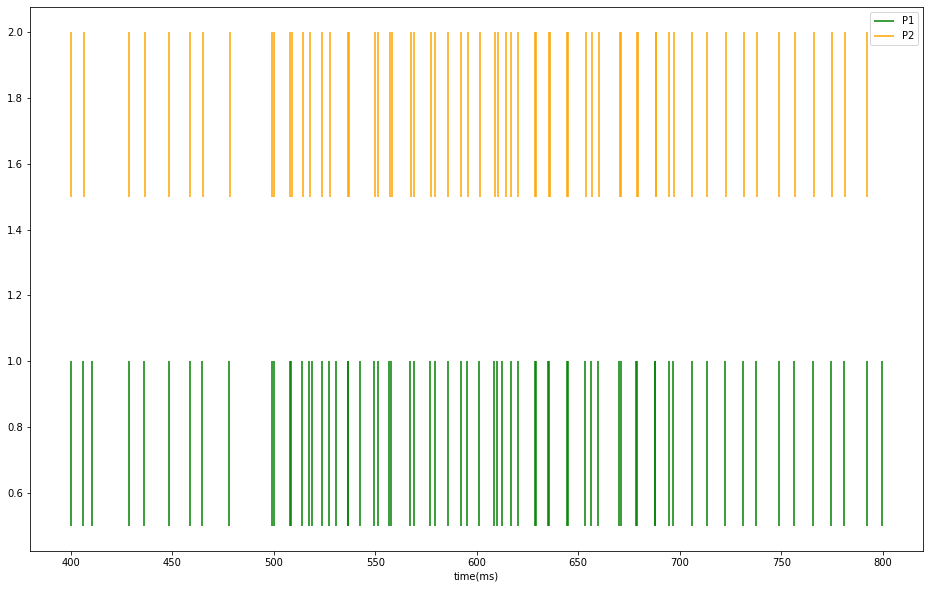

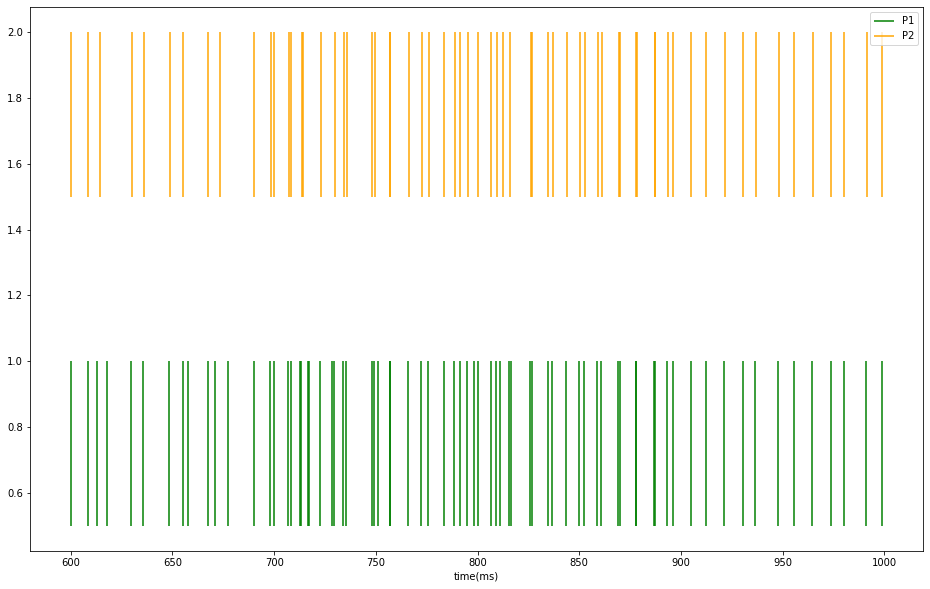

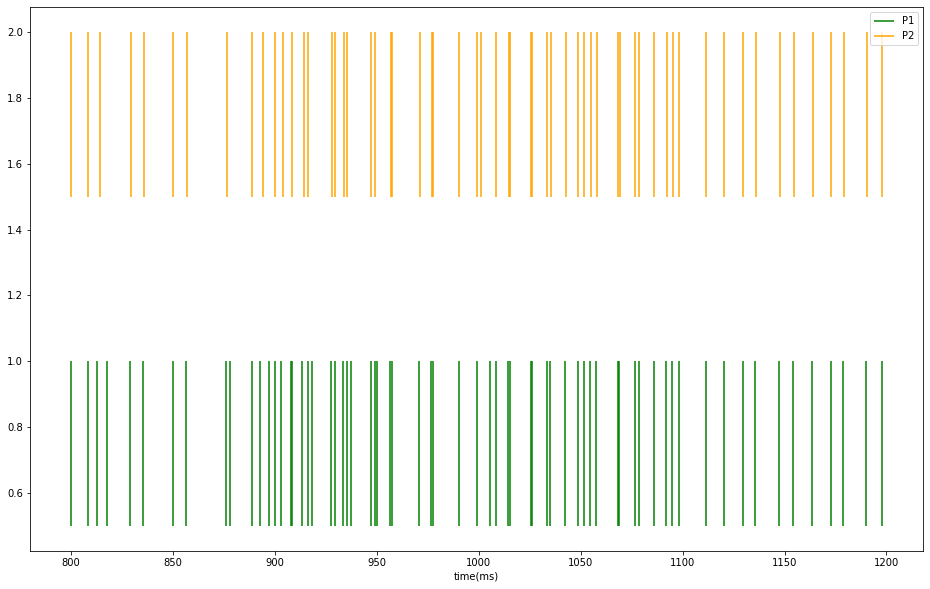

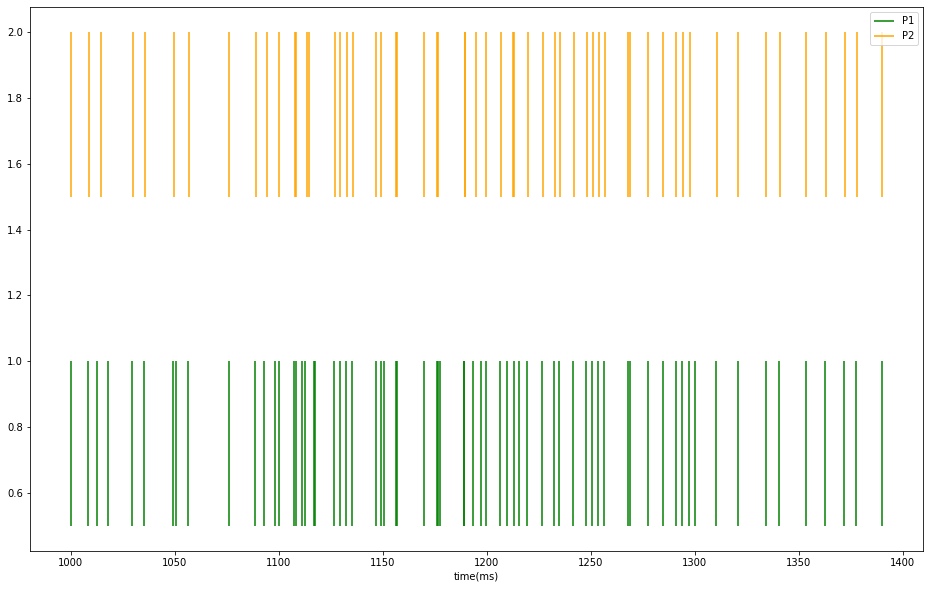

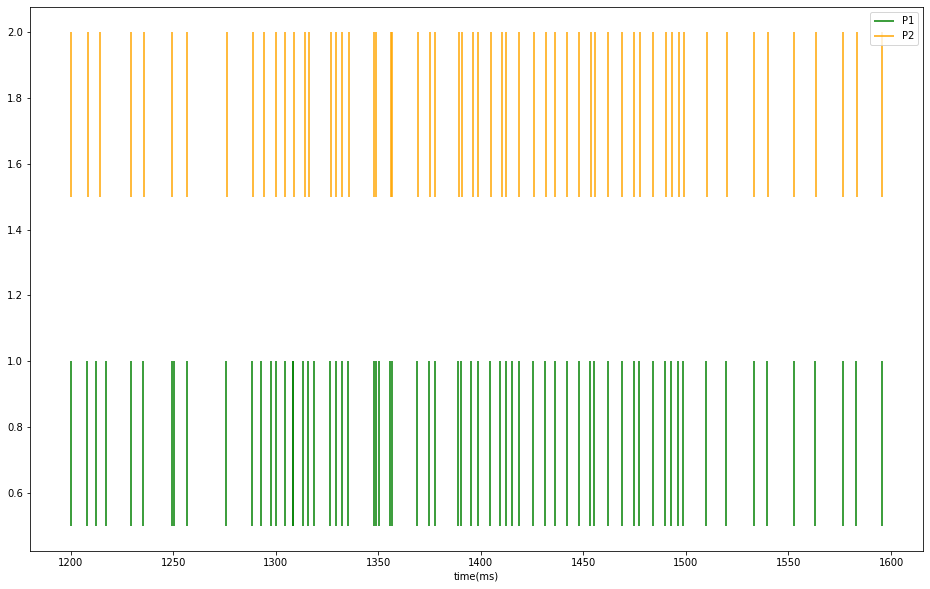

In [50]:
interval=2 #no.of pairs for each raster scan(if interval is 1 each pair would be displayed individually)
start=0
end=interval
lis=int(size/end)
for k in range(lis):
  color=['green','orange']
  label=['P1','P2']
  plt1.figure(figsize=(16,10))
  for j in range(start,end):
      for i,cell in enumerate(L1.sets[j].cells):
          plt1.vlines(cell.spike_times+(100*j), i + 0.5, i + 1,color=color[i])
  plt1.xlabel('time(ms)')
  plt1.legend(label)
  start=end
  end=end+interval


[0.025000000100000003, 10.250000000099952, 22.07500000009928, 31.650000000098736, 41.625000000100904, 50.15000000010284, 73.20000000010808, 80.10000000010965, 102.67500000011478, 120.02500000011872, 143.20000000010668, 153.42500000009738, 163.45000000008827, 176.15000000007672, 186.57500000006723, 196.52500000005818, 206.15000000004943, 212.62500000004354, 225.62500000003172, 239.7250000000189, 246.70000000001255, 255.8750000000042, 267.89999999999327, 280.6999999999816, 289.7749999999734, 298.92499999996505]
[0.025000000100000003, 10.250000000099952, 22.07500000009928, 31.650000000098736, 41.625000000100904, 50.15000000010284, 73.20000000010808, 80.10000000010965, 102.67500000011478, 120.02500000011872, 143.20000000010668, 153.42500000009738, 163.45000000008827, 176.15000000007672, 186.57500000006723, 196.52500000005818, 206.15000000004943, 212.62500000004354, 225.62500000003172, 239.7250000000189, 246.70000000001255, 255.8750000000042, 267.89999999999327, 280.6999999999816, 289.77499

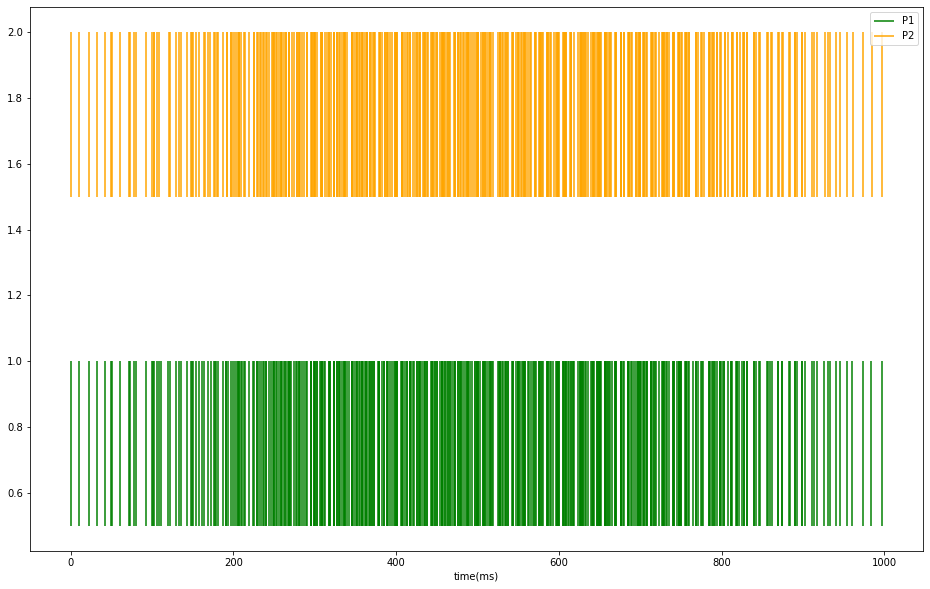

In [51]:
color=['green','orange']
label=['P1','P2']
plt1.figure(figsize=(16,10))
for j in range(given_input_from_user):
    for i,cell in enumerate(L1.sets[j].cells):
        plt1.vlines(cell.spike_times+(50*j), i + 0.5, i + 1,color=color[i])
plt1.xlabel('time(ms)')
plt1.legend(label)
t1=list(L1.sets[0].cells[0].spike_times)
t2=list(L1.sets[0].cells[0].spike_times)
print(t1)
print(t2)

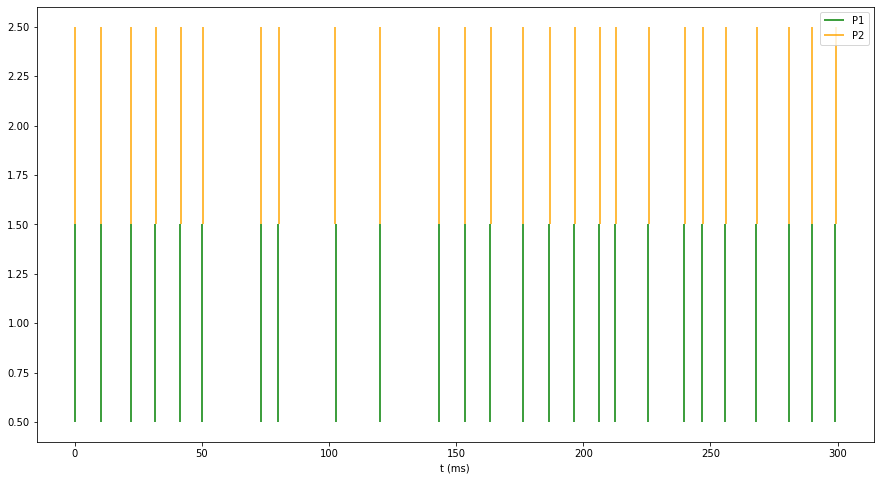

In [52]:
color=['green','orange']
label=['P1','P2']
plt1.figure(figsize=(15,8))
for i,cell in enumerate(L1.sets[0].cells):
    plt1.vlines(cell.spike_times, i + 0.5, i + 1.5,color=color[i],label=label[i])
plt1.xlabel('t (ms)')
plt1.legend()
plt1.show()

In [53]:
%load_ext google.colab.data_table
import pandas
P1_spike_times = list(L1.sets[0].cells[0].spike_times)
P2_spike_times = list(L1.sets[0].cells[1].spike_times)

padding = len(P1_spike_times) - len(P2_spike_times)
P2_spike_times.extend([0 for i in range(padding)]) if padding > 0 else P1_spike_times.extend([0 for i in range(-padding)])
# print(len(P1_spike_times), len(P2_spike_times))
data = {'P1 before learning': P1_spike_times, 'P2 before learning' : P2_spike_times}
pandas.DataFrame(data)

The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table


P1 before learning  P2 before learning
0                0.025               0.025
1               10.250              10.500
2               22.075              22.300
3               31.650              31.900
4               41.625              41.875
5               50.150              50.400
6               73.200              73.325
7               80.100              80.400
8              102.675             102.400
9              120.025             120.175
10             143.200             143.325
11             153.425             153.675
12             163.450             163.700
13             176.150             176.350
14             186.575             186.800
15             196.525             196.775
16             206.150             206.400
17             212.625             212.950
18             225.625             225.800
19             239.725             239.925
20             246.700             247.000
21             255.875             256.200
22             267.900             268.125
23             280.700             280.900
24             289.775             290.025
25             298.925             299.175

In [54]:
# n=2*size-1
# final_weights=[0]*n
# labels=range(2*size-1)
# initial_weights =weights[0:n]
# for i in range(size):
#   final_weights[i]=weights_rec[i][-1]
# """
# for i in range(size,2*size-1):
#   final_weights.insert(i,weights[i])
# """
# for i in range(size-1):
#   final_weights[i+size]= L_weights_rec[i][-1]

# #final_weights=final_weights[0:n]  

# print(initial_weights)
# print(final_weights)

# plt1.figure(figsize=(16,9))
# x = np.arange(len(labels))  # the label locations
# width = 0.15  # the width of the bars
 
# fig, ax = plt1.subplots()
# rects1 = ax.bar(x - width/2,initial_weights, width, label='initial')
# rects2 = ax.bar(x + width/2,final_weights , width, label='final')
 
# # Add some text for labels, title and custom x-axis tick labels, etc.
# ax.set_ylabel('weights')
# ax.set_xticks(x)
# ax.set_xticklabels(labels)
# ax.legend()
# ax.grid()
# fig.tight_layout()
# for i, v in enumerate(final_weights):
#     ax.text(i,v, str(round(v,3)), color = 'blue', fontweight = 'bold')
# for i, v in enumerate(initial_weights):
#     ax.text(i-0.23,v, str(round(v,3)), color = 'red')
# plt1.show()

### **After learning firing rate**

In [55]:
# fr_P1_1=[0 for i in range(len(L1.sets))]
# fr_P2_1=[0 for i in range(len(L1.sets))]
# c_1=[0 for i in range(size*2)]
# for f in range(len(L1.sets)):
#   t=list(L1.sets[f].cells[0].spike_times)
#   t1=list(L1.sets[f].cells[1].spike_times)
#   fr_P1_1[f]=(len(t)/100)*1000  # length of t= no.of spikes
#   fr_P2_1[f]=(len(t1)/100)*1000
# #print("frequencies of P1 in each set", fr_P1_1)
# #print("frequencies of P2 in each set", fr_P2_1)
# for i in range(size):
#   c_1[i*2]=fr_P1_1[i]
#   c_1[i*2+1]=fr_P2_1[i]
# print("Frequencies of each neuron after learning", c_1)

In [56]:
# neuron_name=[0 for i in range(size*2)]
# import plotly.graph_objects as go

# for i in range(2*size):
#   neuron_name[i]="p{0}".format(i+1)
# print(neuron_name)

# fig = go.Figure()

# fig.add_trace(go.Scatter(x=neuron_name, y=c, marker=dict(color="crimson", size=9), mode="markers", name="Before Lering"))


# fig.add_trace(go.Scatter(x=neuron_name, y=c_1, marker=dict(color="green", size=9), mode="markers", name="After Learning"))

# fig.update_layout(title="firing rate", xaxis_title="neuron", yaxis_title="Frequency")

# print("Frequencies of each neuron before learning", c)
# print("Frequencies of each neuron after learning", c_1)

# fig.show()

In [57]:
# label=['histogram']
# n=size
# labels=range(2*size)

# plt1.figure(figsize=(16,9))
# x = np.arange(len(labels))  # the label locations
# width = 0.15  # the width of the bars
 
# fig, ax = plt1.subplots()
# rects1 = ax.bar(x - width/2,c, width, label='Before Learning')
# rects1 = ax.bar(x + width/2,c_1, width, label='After Learning')
 
# # Add some text for labels, title and custom x-axis tick labels, etc.
# ax.set_ylabel('frequency in HZ')
# ax.set_xticks(x)
# ax.set_xticklabels(labels)
# ax.legend()
# ax.grid()
# fig.tight_layout()
# for i, v in enumerate(c):
#     ax.text(i,v, str(round(v,3)), color = 'blue', fontweight = 'bold')
#     for i, v in enumerate(c_1):
#       ax.text(i,v, str(round(v,3)), color = 'green', fontweight = 'bold')
# plt1.show()

# count, bins, ignored = plt1.hist(c, 20)
# plt1.legend(label)
# plt1.xlabel('firing rate')
# plt1.ylabel('no of neurons')
# plt1.show()

# count, bins, ignored = plt1.hist(c_1, 20)
# plt1.legend(label)
# plt1.xlabel('firing rate')
# plt1.ylabel('no of neurons')
# plt1.show()


In [58]:
# """
# from scipy.stats import skew
# plt1.hist(weights, bins=10)
# print(weights)
# print(skew(weights))
# plt1.show()
# """